# Some functions to calculate gs_model and plots

In [10]:
from lmfit import Model, Parameters, Parameter
import numpy as np
import pandas as pd
from atmosp import calculate as ac
import numpy as np
from scipy.optimize import minimize
from pathlib import Path
import supy as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
import random
import pickle
import os
import warnings
warnings.filterwarnings('ignore')
from shutil import copyfile
from IPython.display import clear_output
from gs_util import read_forcing,modify_attr,cal_gs_obs,IQR_compare,obs_sim,cal_gs_mod,gs_plot_test,modify_attr_2,func_parse_date

# Preparing the data (obs and model)

In [11]:
name='CA-Obs' 
year=2008
df_forcing= read_forcing(name,year)

In [12]:
def run_LAI_states(z0f,zdf,df_forcing_run,df_state_init,name,year,doy_LAI,path_runcontrol):
    
    
    start_date=datetime.datetime(year, 1, 1) + datetime.timedelta(1 - 1)
    all_attrs = pd.read_csv('all_attrs.csv')
    attrs_site = all_attrs[all_attrs.site == name]
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][0]
    ma=df_state_init.loc[:,'laimax'].values[0][0]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]
    
    
    
    counter=0
    all_LAI_output=pd.DataFrame()

    for idx,end_day in enumerate(doy_LAI):
        end_date=datetime.datetime(year, 1, 1) + datetime.timedelta(int(end_day)- 1)
        print(start_date,end_date)

        if counter>0:
            final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
            df_state_init.iloc[0] = final_state


        df_state_init.loc[:,'z0m_in']=attrs_site.height.values[0]*z0f[counter]
        df_state_init.loc[:,'zdm_in']=attrs_site.height.values[0]*zdf[counter]
        df_output, df_state_final = sp.run_supy(df_forcing_run.loc[start_date:end_date], df_state_init, save_state=False)


        all_LAI_output=all_LAI_output.append(df_output.SUEWS.loc[grid])

        start_date=end_date+datetime.timedelta(1)
        counter+=1

    end_date=datetime.datetime(year, 1, 1) + datetime.timedelta(365- 1)
    print(start_date,end_date)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    df_state_init.loc[:,'z0m_in']=attrs_site.height.values[0]*z0f[counter]
    df_state_init.loc[:,'zdm_in']=attrs_site.height.values[0]*zdf[counter]
    df_output, df_state_final = sp.run_supy(df_forcing_run.loc[start_date:end_date], df_state_init, save_state=False)
    all_LAI_output=all_LAI_output.append(df_output.SUEWS.loc[grid])
    
    return df_state_final,all_LAI_output

In [13]:
path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
df_state_init = sp.init_supy(path_runcontrol)
df_state_init,level=modify_attr(df_state_init,name)
df_state_init.loc[:,'soilstore_id']=[50,50,50,50,50,50,0]


grid = df_state_init.index[0]
df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)
df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)
df_forcing_run.lai=df_output.SUEWS.loc[grid,:].LAI


with open('../outputs/roughness/all_periods_train.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


error=10
for i in range(10):
    if (error <= 0.1):
        break
    clear_output()
    df_state_final,all_LAI_output=run_LAI_states(z0f,zdf,df_forcing_run,
                                                 df_state_init,name,
                                                 year,doy_LAI,
                                                 path_runcontrol)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


2008-01-01 00:00:00 2008-04-14 00:00:00
2020-04-03 14:43:19,666 — SuPy — INFO — ====================
2020-04-03 14:43:19,667 — SuPy — INFO — Simulation period:
2020-04-03 14:43:19,669 — SuPy — INFO —   Start: 2008-01-01 00:00:00
2020-04-03 14:43:19,678 — SuPy — INFO —   End: 2008-04-14 00:00:00
2020-04-03 14:43:19,682 — SuPy — INFO — 
2020-04-03 14:43:19,684 — SuPy — INFO — No. of grids: 1
2020-04-03 14:43:19,685 — SuPy — INFO — SuPy is running in serial mode
2020-04-03 14:43:24,120 — SuPy — INFO — Execution time: 4.5 s
2020-04-03 14:43:24,124 — SuPy — INFO — ====================

2008-04-15 00:00:00 2008-06-16 00:00:00
2020-04-03 14:43:24,145 — SuPy — INFO — ====================
2020-04-03 14:43:24,146 — SuPy — INFO — Simulation period:
2020-04-03 14:43:24,148 — SuPy — INFO —   Start: 2008-04-15 00:00:00
2020-04-03 14:43:24,151 — SuPy — INFO —   End: 2008-06-16 00:00:00
2020-04-03 14:43:24,153 — SuPy — INFO — 
2020-04-03 14:43:24,164 — SuPy — INFO — No. of grids: 1
2020-04-03 14:43:24

In [14]:
df=all_LAI_output.resample('1h',closed='left',label='right').mean()

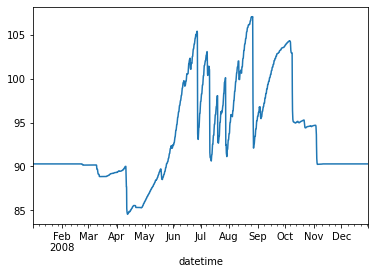

In [15]:
df.SMD.plot()

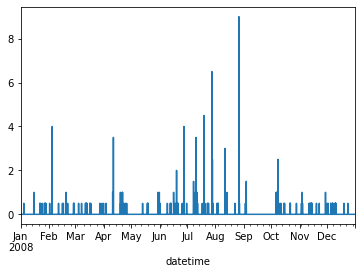

In [16]:
df_forcing.rain.plot()

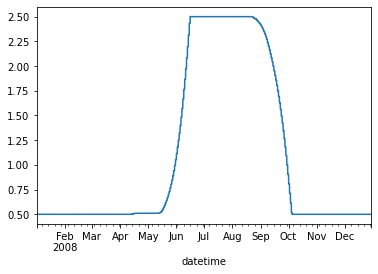

In [17]:
df.LAI.plot()

In [18]:
df_forcing.xsmd=df.SMD
df_forcing.lai=df.LAI
df_forcing = df_forcing[df_forcing.qe > 0]
df_forcing = df_forcing[df_forcing.qh > 0]
df_forcing = df_forcing[df_forcing.kdown > 5]
df_forcing = df_forcing[df_forcing.Tair > -20]
df_forcing.pres *= 1000
df_forcing.Tair += 273.15
gs_obs = cal_gs_obs(df_forcing.qh, df_forcing.qe, df_forcing.Tair,
                        df_forcing.RH, df_forcing.pres,df.RA)
df_forcing=df_forcing[gs_obs>0]
gs_obs=gs_obs[gs_obs>0]
df_forcing=df_forcing.replace(-999,np.nan)

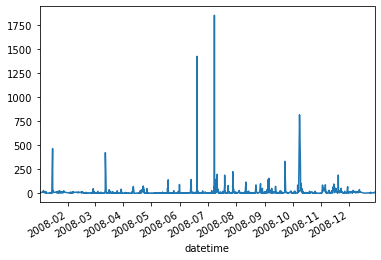

In [19]:
gs_obs.plot()

(-50.0, 400.0)

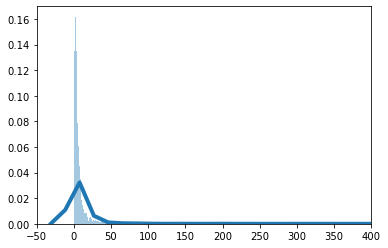

In [20]:
sns.distplot(gs_obs.values,hist=True, kde=True,bins=int(2000),kde_kws={'linewidth': 4})
plt.xlim((-50,400))

In [21]:
g_max=np.percentile(gs_obs,99)
s1=5.56

In [22]:
g_max

91.46368317811394

In [23]:
df_forcing=df_forcing[gs_obs<g_max]
#lai_max=df_forcing.lai.max()
lai_max=df_state_init.laimax.loc[grid,:][0]
gs_obs=gs_obs[gs_obs<g_max]


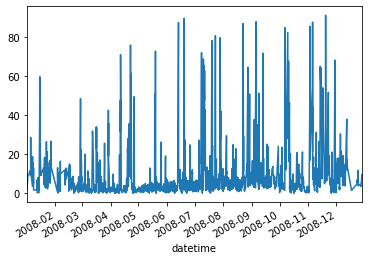

In [24]:
gs_obs.plot()

In [25]:
lai_max

2.5

# Splitting the data to test and train

In [26]:
df_forcing_train, df_forcing_test, gs_train, gs_test = train_test_split(df_forcing, gs_obs, test_size=0.6, random_state=42)

In [27]:
kd=df_forcing_train.kdown
ta=df_forcing_train.Tair
rh=df_forcing_train.RH
pa=df_forcing_train.pres
smd=df_forcing_train.xsmd
lai=df_forcing_train.lai

# Optimization

## More info in [here](https://platypus.readthedocs.io/en/latest/getting-started.html#)

In [28]:
def fun_to_opts(G):
    [g1,g2, g3, g4, g5, g6]=[G[0],G[1],G[2],G[3],G[4],G[5]]
    gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_z=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
    gs_obs=gs_train
    o1=abs(1-np.std(gs_model)/np.std(gs_obs)) # normilized std difference
    o2=np.mean(abs(gs_model-gs_obs))/(np.mean(gs_obs))
    return [o1,o2],[gs_model.min()]

In [29]:
problem = Problem(6,2,1)
problem.types[0] = Real(.05, .5)
problem.types[1] = Real(100, 500)
problem.types[2] = Real(0, 1)
problem.types[3] = Real(0.4, 1)
problem.types[4] = Real(25, 55)
problem.types[5] = Real(0.02, 0.03)

problem.constraints[0] = ">=0"

problem.function = fun_to_opts
random.seed(12345)
algorithm=CMAES(problem, epsilons=[0.005])
algorithm.run(3000)


In [30]:
print( " Obj1\t Obj2")

for solution in algorithm.result[:10]:
    print ("%0.3f\t%0.3f" % tuple(solution.objectives))

 Obj1	 Obj2
0.048	1.481
0.245	1.234
0.348	1.113
0.365	1.095
0.283	1.188
0.254	1.223
0.678	0.808
0.414	1.039
0.533	0.919
0.125	1.382


## It shows how two objective changes

Text(0, 0.5, 'objective 2')

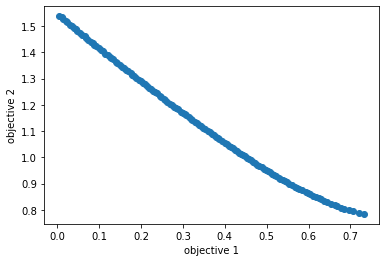

In [31]:
f, ax = plt.subplots(1, 1)
plt.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

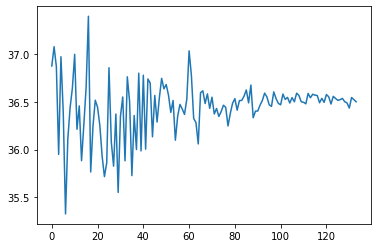

In [32]:
all_G={
      'g2':[],
      'g3':[],
      'g4':[],
      'g5':[],
      'g6':[]
      }
for s in algorithm.result:
        all_G['g2'].append(s.variables[0])
        all_G['g3'].append(s.variables[1])
        all_G['g4'].append(s.variables[2])
        all_G['g5'].append(s.variables[3])
        all_G['g6'].append(s.variables[4])
plt.plot(all_G['g6'])

In [33]:
all_std=[s.objectives[0] for s in algorithm.result]
all_MAE=[s.objectives[1] for s in algorithm.result]
all_std=np.array(all_std)
all_MAE=np.array(all_MAE)

## Choosing between : the median of two objectives, where obj1 is max or where obj2 is max

In [34]:
method='median' # 'obj1' or 'obj2' or 'median'
colors= ['b','g','r','y']

if method == 'median':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.median(all_std))].min())[0][0]
elif method == 'obj1':
    idx_med=np.where(all_MAE==all_MAE[(all_std>=np.min(all_std))].max())[0][0]
elif method == 'obj2':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.max(all_std))].min())[0][0]
print(all_std[idx_med])
print(all_MAE[idx_med])


0.3337984868655277
1.129260788946374


In [35]:
[g1,g2,g3,g4,g5,g6] = algorithm.result[idx_med].variables

In [36]:
with open('g1-g6/'+name+'-g1-g6','wb') as f:
    pickle.dump([g1,g2,g3,g4,g5,g6], f)

In [37]:
with open('g1-g6/'+name+'-g1-g6','rb') as f:
    [g1,g2,g3,g4,g5,g6]=pickle.load(f)

In [38]:

pd.DataFrame([np.round([g1,g2,g3,g4,g5,g6],3)],columns=['g1','g2','g3','g4','g5','g6'],index=[name])

,g1,g2,g3,g4,g5,g6
CA-Obs,0.286,104.646,0.702,0.632,36.623,0.022


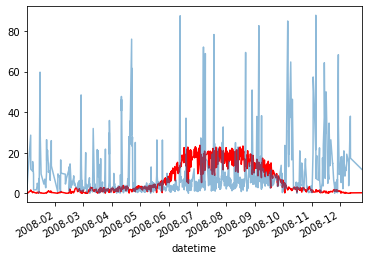

In [39]:
gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_max=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)

gs_model.plot(color='r')
gs_train.plot(alpha=0.5)

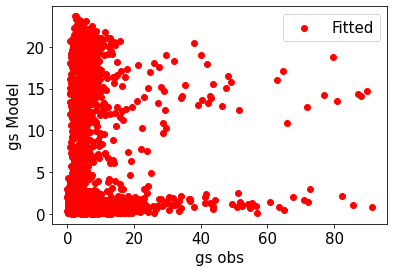

In [40]:
kd_test=df_forcing_test.kdown
ta_test=df_forcing_test.Tair
rh_test=df_forcing_test.RH
pa_test=df_forcing_test.pres
smd_test=df_forcing_test.xsmd
lai_test=df_forcing_test.lai



gs_model_test,g_lai,g_kd,g_dq,g_ta,g_smd,g_m=cal_gs_mod(kd_test, ta_test, rh_test, pa_test, smd_test, lai_test,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
# gs_model_helen,g_lai,g_kd,g_dq,g_ta,g_smd,g_m=cal_gs_mod(kd_test, ta_test, rh_test, pa_test, smd_test, lai_test,
#                           [3.5, 200, 0.13, 0.7, 30, .05],
#                           g_max, lai_max, s1)

plt.rc('font', size=15)
f, ax = plt.subplots(1, 1)
plt.scatter(gs_test.values,gs_model_test.values,color='r',alpha=1,label='Fitted')
#plt.scatter(gs_test.values,gs_model_helen.values,color='b',alpha=0.4,label='Helen')
plt.xlabel('gs obs')
plt.ylabel('gs Model')
plt.legend()
plt.savefig('figs/compare_test-gs-'+name+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)


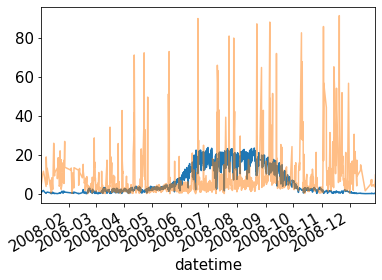

In [41]:
gs_model_test.plot()
gs_test.plot(alpha=0.5)

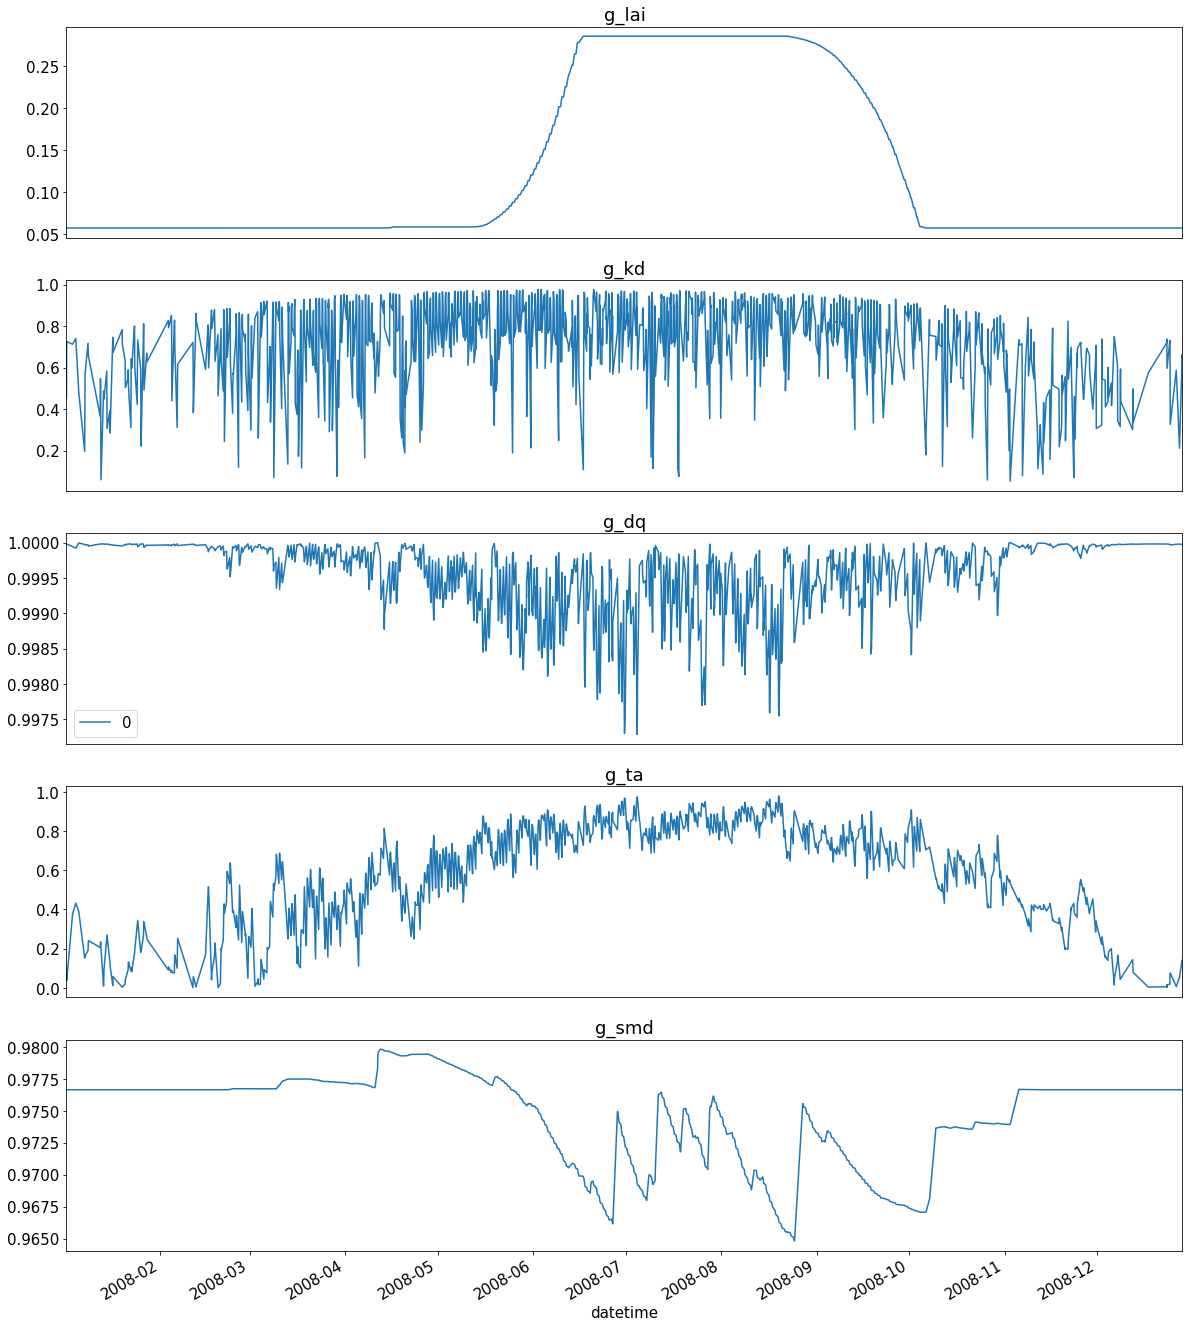

In [42]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    a[str(i)].plot(ax=ax)
    ax.set_title(b[str(i)])
    if i!=4:
        ax.set_xticks([''])
        ax.set_xlabel('')
    
    

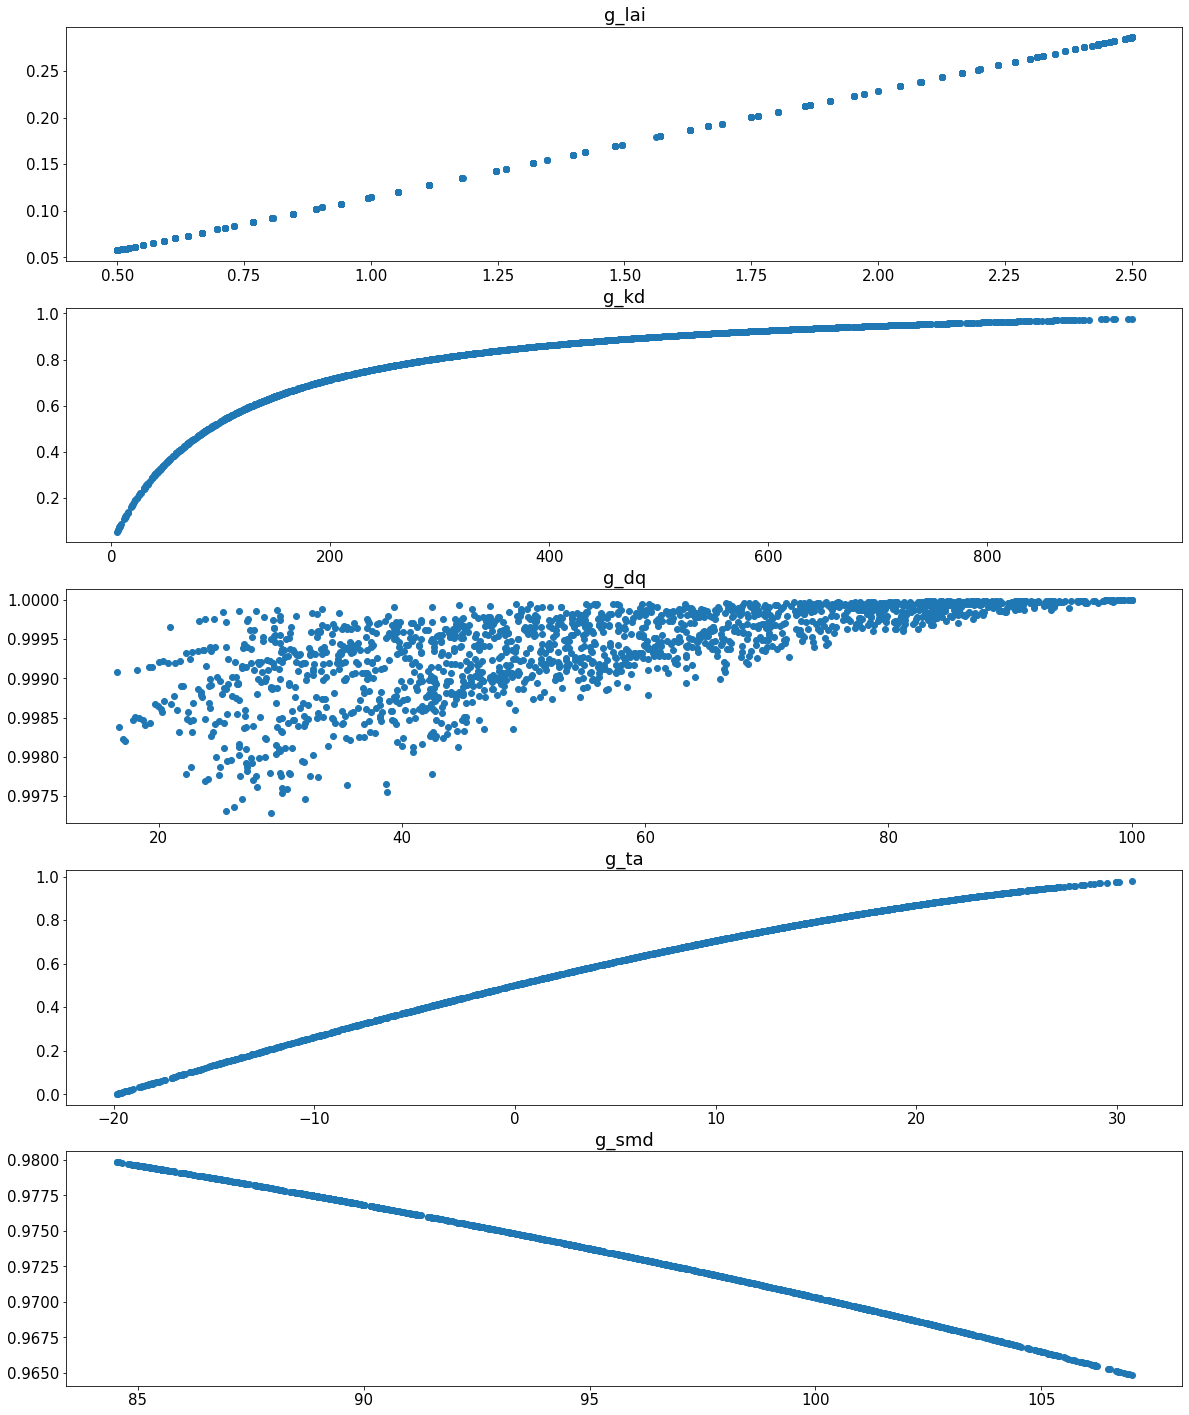

In [43]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
c={'0':lai_test,'1':kd_test,'2':rh_test,'3':ta_test-273,'4':smd_test}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    ax.scatter(c[str(i)],a[str(i)])
    ax.set_title(b[str(i)])
    if i!=4:
        #ax.set_xticks([''])
        ax.set_xlabel('')
    
    

In [44]:
print(abs(gs_model_test-gs_test).mean())

8.584596560127219


In [45]:
def gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI,alpha=1,helen=0):

    path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)
    df_state_init,level=modify_attr(df_state_init,name)
    grid = df_state_init.index[0]


    df_state_init.g1=g1*alpha
    df_state_init.g2=g2
    df_state_init.g3=g3
    df_state_init.g4=g4
    df_state_init.g5=g5
    df_state_init.g6=g6
    df_state_init=modify_attr_2(df_state_init,g_max,s1)
    
    
    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)
    df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)
    df_forcing_run.lai=df_output.SUEWS.loc[grid,:].LAI
    
    
    
    df_state_final,all_LAI_output=run_LAI_states(z0f,zdf,df_forcing_run,
                                                 df_state_init,name,year,doy_LAI,path_runcontrol)
    clear_output()

    df_obs=pd.read_csv('runs/run'+'/Input/'+'kc'+'_2012_data_60.txt',sep=' ',
                                    parse_dates={'datetime': [0, 1, 2, 3]},
                                    keep_date_col=True,
                                    date_parser=func_parse_date)

    df_obs= df_obs.set_index('datetime')

    fig,axs=plt.subplots(4,1,figsize=(8,15))
    plt.subplots_adjust(hspace=.8)
    plt.rc('font', size=15)

    ax=axs[0]
    df_obs_temp=df_obs.replace(-999,np.nan)
    
    df=all_LAI_output
    df=df.resample('1h',closed='left',label='right').mean()
    
    IQR_compare('qe','QE',df_obs_temp,df,ax)
    ax.legend()
    ax.set_title('QE (test data set-fitted g1-g6)')
    ax.set_ylabel('QE (W m$^{-2}$)')
    ax.set_xlabel('Time (UTC)')


    df=all_LAI_output
    df=df.resample('1h',closed='left',label='right').mean()
    df=df.dropna(how='all')
    df_temp=df_obs_temp[df_obs_temp.qe<700]
    
    plt.rc('font', size=15)

    data_for_plot={'IQR':{'obs':df_obs_temp,'model':df}}
    data_for_plot['obs_sim']={'obs':df_temp,'model':df.loc[df_temp.index,:]}

    if helen==0:
        with open('surface_conductance/'+name+'-'+str(year),'wb') as f:
            pickle.dump(data_for_plot, f)
    elif helen==1:
        with open('surface_conductance/'+name+'-'+str(year)+'-Helen','wb') as f:
            pickle.dump(data_for_plot, f)

    ax=axs[1]
    obs_sim('qe','QE',df_temp,df.loc[df_temp.index,:],ax)

    ax.set_ylabel('Model')
    ax.set_xlabel('Obs')
    ax.set_title('QE-test data-all season-MAE='+str(np.round(np.mean(abs(df.loc[df_temp.index,:].QE-df_temp.qe)),2)))
    

    ax=axs[2]
    all_LAI_output.QE.resample('1h',closed='left',label='right').mean().plot(ax=ax,label='model')
    ax.legend()
    ax=axs[3]
    df_obs[df_obs.qe>0].qe.plot(ax=ax,label='obs')
    ax.legend()
    

## Running Supy with new g1-g6

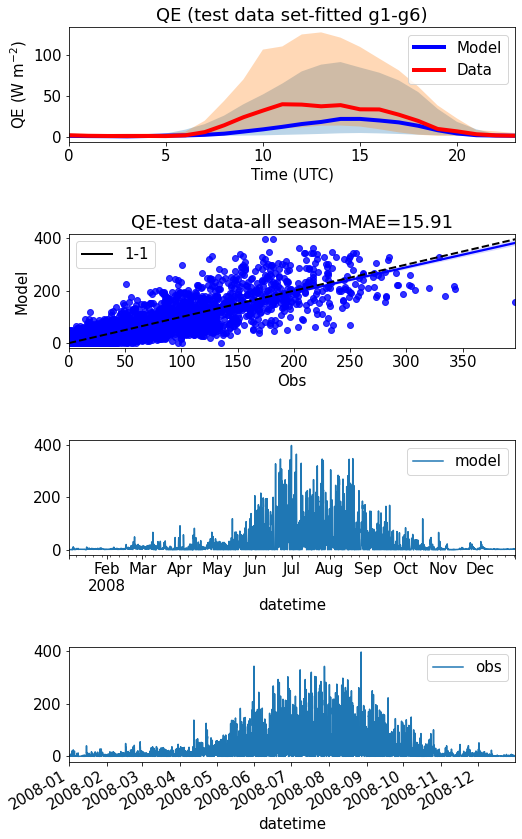

In [48]:
alpha=.57
name='CA-Obs'
year=year


with open('../outputs/roughness/all_periods_train.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]

gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI,alpha)

In [49]:
g1=g1*alpha

In [50]:
g1*g_max

14.9134744593889

In [51]:
g_max=g1*g_max
g1=1


In [52]:
g_max

14.9134744593889

### looking at each season

In [53]:
# path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
# df_state_init = sp.init_supy(path_runcontrol)
# grid = df_state_init.index[0]
# df_forcing = sp.load_forcing_grid(path_runcontrol, grid)

# df_state_init.g1=g1
# df_state_init.g2=g2
# df_state_init.g3=g3
# df_state_init.g4=g4
# df_state_init.g5=g5
# df_state_init.g6=g6


# df_state_init,level=modify_attr(df_state_init,name)
# f_state_init=modify_attr_2(df_state_init,g_max,s1)

# df_output, df_state_final = sp.run_supy(df_forcing, df_state_init, save_state=False)

In [54]:
# df=df_output.SUEWS.loc[grid,:]
# df=df.resample('1h',closed='left',label='right').mean()
# df_temp=df_forcing_test.replace(-999,np.nan)
# df=df.loc[df_temp.index,:]
# months_model = [g for n, g in df.groupby(pd.Grouper(freq='M'))]
# plt.rc('font', size=15)
# f=plt.figure(figsize=(15,15))
# f.suptitle(name+' Test data-QE',size=35)

# month_name=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
# for i in range(0,12):
#     plt.rc('font', size=15)
#     ax=plt.subplot(4,3,i+1)
#     obs_sim('qe','QE',df_temp,months_model[i],ax)

#     plt.ylabel('Model')
#     plt.xlabel('Obs')
#     plt.title(month_name[i]+': MAE='+str(np.round(np.mean(abs(months_model[i].QE-df_temp.qe)),2)))
# plt.tight_layout()
# f.subplots_adjust(top=.9)

In [55]:
# df_obs=pd.read_csv('runs/run'+'/Input/'+'kc'+'_2012_data_60.txt',sep=' ',
#                                     parse_dates={'datetime': [0, 1, 2, 3]},
#                                     keep_date_col=True,
#                                     date_parser=func_parse_date)

# df_obs= df_obs.set_index('datetime')
# df_output, df_state_final = sp.run_supy(df_forcing, df_state_init, save_state=False)
# df_obs_temp=df_obs.replace(-999,np.nan)
# df=df_output.SUEWS.loc[grid,:]
# df=df.resample('1h',closed='left',label='right').mean()
# months_model = [g for n, g in df.groupby(pd.Grouper(freq='M'))]
# plt.rc('font', size=15)
# f=plt.figure(figsize=(15,15))
# f.suptitle(name+' All data-QE',size=35)
# month_name=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
# for i in range(0,12):
#     plt.rc('font', size=15)
#     ax=plt.subplot(4,3,i+1)
#     IQR_compare('qe','QE',df_obs_temp.loc[months_model[i].index,:],months_model[i],ax)

#     plt.ylabel('QE (W m$^{-2}$)')
#     plt.xlabel('Time (UTC)')
#     plt.legend()
#     plt.title(month_name[i]+': MAE='+str(np.round(np.mean(abs(months_model[i].QE-df_obs_temp.qe)),2)))
# plt.tight_layout()
# f.subplots_adjust(top=.9)


# Creating the table for all sites here

In [56]:
sites=['Swindon','London','US-MMS','US-Blk','US-SRG','CA-Obs','Kc','Sw']
g1_g6_all=pd.DataFrame(columns=['g1','g2','g3','g4','g5','g6'])

for s in sites:
    with open('g1-g6/'+s+'-g1-g6','rb') as f:
        g1_g6_all.loc[s,:]=pickle.load(f)
g1_g6_all  

,g1,g2,g3,g4,g5,g6
Swindon,2.46186,111.283,0.649472,0.263545,1.22068,0.0972639
London,4.45704,104.601,0.439791,0.594791,20.3764,0.0766758
US-MMS,0.400417,104.1,0.158907,0.574179,25.9256,0.0280402
US-Blk,1,267.197,0.162215,0.641343,34.6575,0.0200774
US-SRG,1,266.156,0.779166,0.739141,18.0336,0.0383004
CA-Obs,0.286059,104.646,0.702473,0.631525,36.6235,0.021617
Kc,1,251.15,0.528526,0.735862,1.58365,0.0316655
Sw,1,266.441,0.40109,0.00885994,16.0812,0.0971404


In [57]:
g_max

14.9134744593889

# To test

## CA-Obs-2006

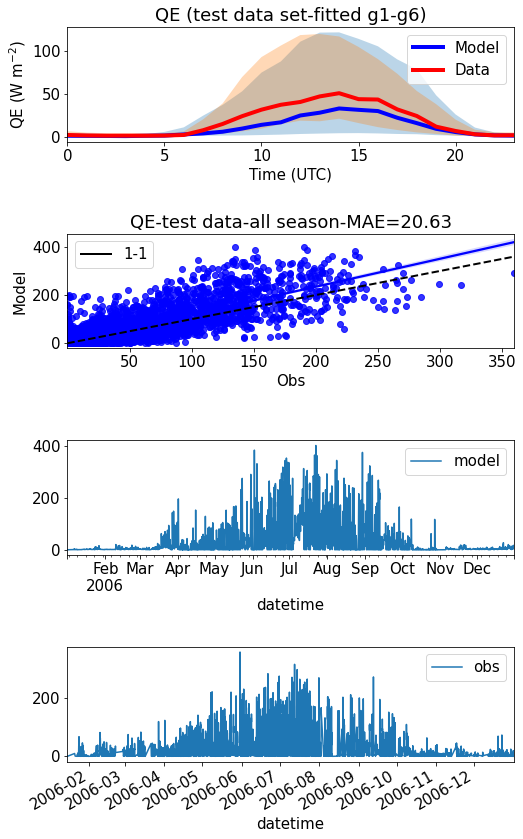

In [58]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56


name='CA-Obs'
year=2006
df_forcing= read_forcing(name,year)

with open('../outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI)

## US-Blk-2006

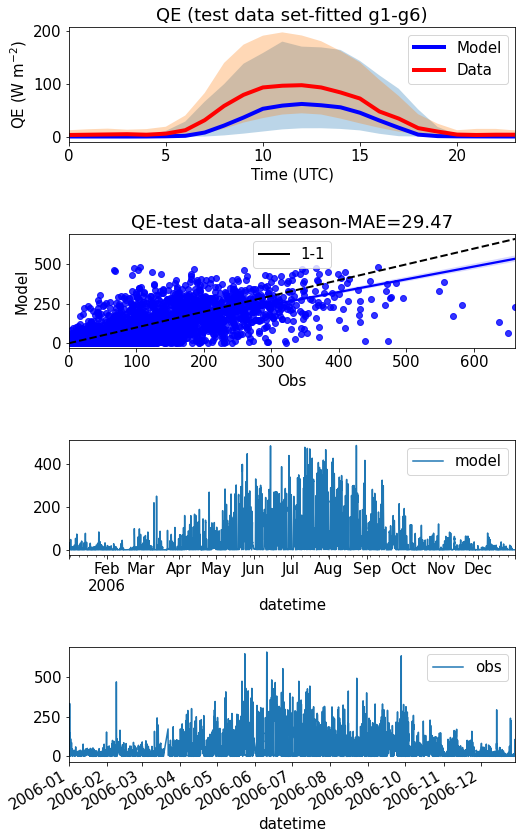

In [59]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56

name='US-Blk'
year=2006
df_forcing= read_forcing(name,year)

with open('../outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI)

## CA-Qcu-2005

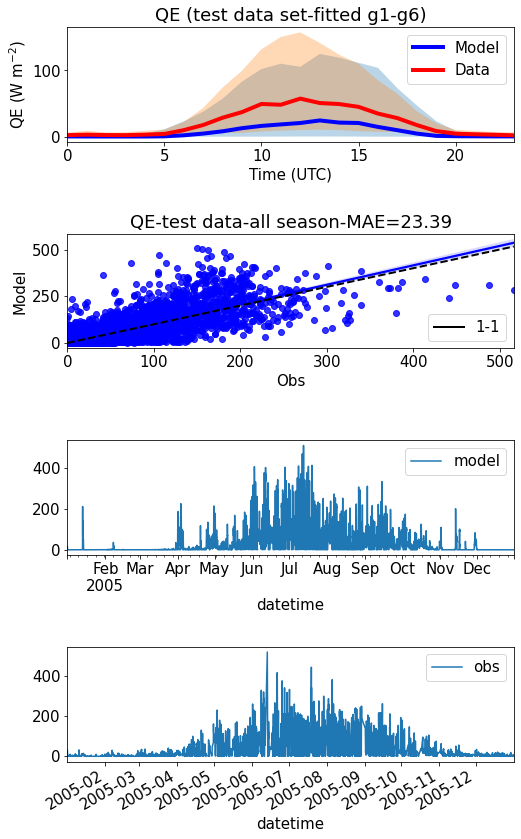

In [60]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56

name='CA-Qcu'
year=2005
df_forcing= read_forcing(name,year)

with open('../outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI)

# With Helen's

## CA-Obs-2006

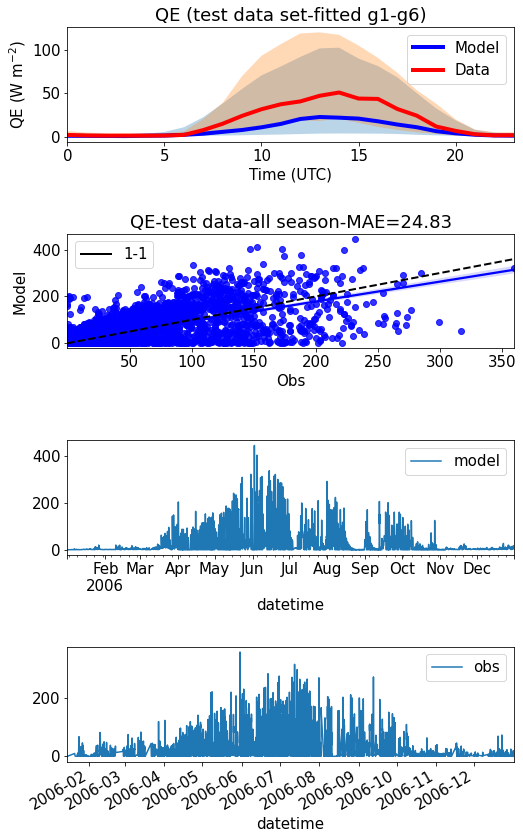

In [61]:
g1,g2,g3,g4,g5,g6=[3.5, 200, 0.13, 0.7, 30, .05]
g_max=33
s1=5.56

name='CA-Obs'
year=2006
df_forcing= read_forcing(name,year)


with open('../outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI,alpha=1,helen=1)

## US-Blk 2006

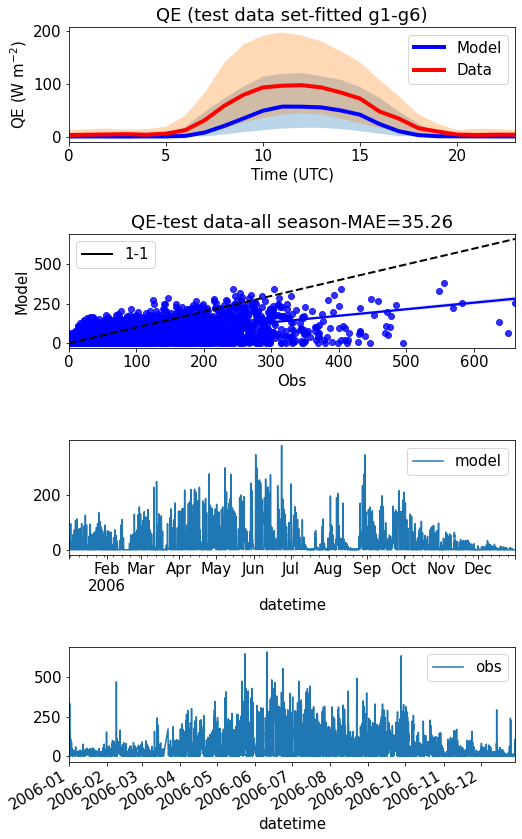

In [62]:
g1,g2,g3,g4,g5,g6=[3.5, 200, 0.13, 0.7, 30, .05]
g_max=33
s1=5.56

name='US-Blk'
year=2006
df_forcing= read_forcing(name,year)


with open('../outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI,alpha=1,helen=1)

## CA-Qcu 2005

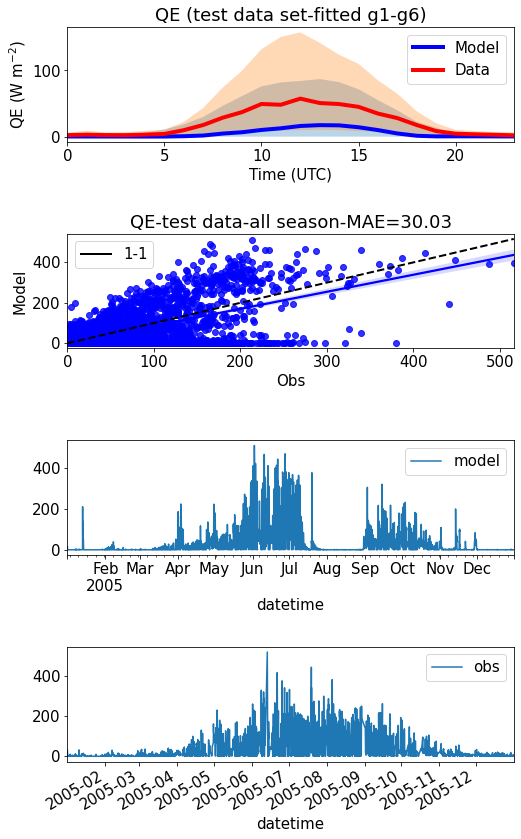

In [63]:
g1,g2,g3,g4,g5,g6=[3.5, 200, 0.13, 0.7, 30, .05]
g_max=33
s1=5.56


name='CA-Qcu'
year=2005
df_forcing= read_forcing(name,year)


with open('../outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI,alpha=1,helen=1)